In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')
!python3 --version

Python 3.6.9 :: Anaconda, Inc.


In [2]:
%%writefile conda_dependencies.yml
dependencies:
    - python=3.6.9
    - numpy=1.18.*
    - pandas=1.1.5
    - pip:
        - azureml-defaults==1.37.0
        - confuse==1.6.0
        - orbit-ml==1.1.0

Overwriting conda_dependencies.yml


In [3]:
%%writefile requirements.txt
confuse==1.6.0
azureml-defaults==1.37.0
confuse==1.6.0
orbit-ml==1.1.0

Overwriting requirements.txt


In [4]:
!pip3 install -r requirements.txt

### **Damped Local Trend (DLT)**

* global and local trend terms

In [5]:
import pandas as pd
import numpy as np
import orbit
from IPython.display import display

In [6]:
display(orbit.__version__)

'1.1.0'

In [7]:
from orbit.utils.dataset import load_iclaims

us_unemp_claims_df = load_iclaims(transform=True).sort_values(by=['week'],ascending=True)
display(us_unemp_claims_df.head())

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


### Train Test Split

* Use last year (52 weeks) of data as *Test*, before that as *Train*

In [42]:
import confuse, os

parent_dir = os.path.dirname(os.getcwd())
config = confuse.Configuration('orbit-dlt-example',__name__)
config.set_file(os.path.join(parent_dir,'config.yaml'))
TIME_COL = config['dlt_uber_provided_example']['utils']['TIME_COL'].get()
RESPONSE_COL = config['dlt_uber_provided_example']['utils']['RESPONSE_COL'].get()
test_ind = config['dlt_uber_provided_example']['utils']['test_ind'].get()
train_df, test_df = us_unemp_claims_df[:-test_ind], us_unemp_claims_df[-test_ind:]

### Three Wrappers for DLT Models

1. ```DLTMAP``` - DLT model for MAP (Maximum a Posteriori)
2. ```DLTFull``` - DLT model for full prediction
    * the prediction occurs as a function of each parameter posterior sample
    * the prediction results are aggregated after prediction
    * prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified
3. ```DLTAggregated``` - DLT model for aggregated posterior prediction
    * the parameter posterior samples are reduced using aggregate_method ```'mean', 'median'``` before performing a single prediction

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.425738,12.362385,0.063352,0.0
1,2017-07-09,12.545887,12.360202,0.185685,0.0
2,2017-07-16,12.382557,12.358019,0.024538,0.0
3,2017-07-23,12.236135,12.355835,-0.119700,0.0
4,2017-07-30,12.189621,12.353652,-0.164031,0.0


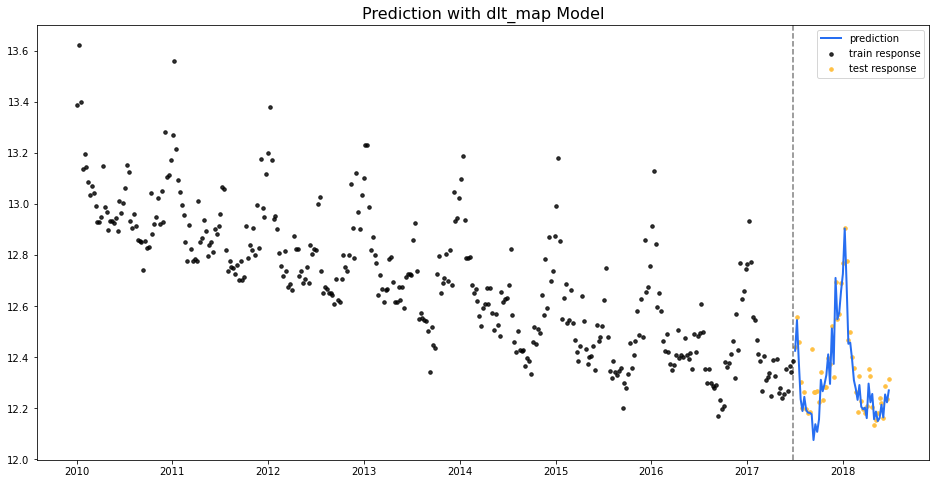

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2017-07-02,12.317017,12.414714,12.505166,12.259992,12.351856,12.454932,0.034175,0.058462,0.078622,0.0,0.0,0.0
1,2017-07-09,12.420335,12.532146,12.650270,12.235730,12.351750,12.462293,0.152519,0.177479,0.196330,0.0,0.0,0.0
2,2017-07-16,12.277873,12.368118,12.484958,12.242626,12.345737,12.447750,0.003939,0.026202,0.048446,0.0,0.0,0.0
3,2017-07-23,12.120210,12.237854,12.345669,12.245931,12.355569,12.472434,-0.140755,-0.116405,-0.094029,0.0,0.0,0.0
4,2017-07-30,12.082805,12.180138,12.249650,12.255381,12.342842,12.425981,-0.187549,-0.162184,-0.141965,0.0,0.0,0.0


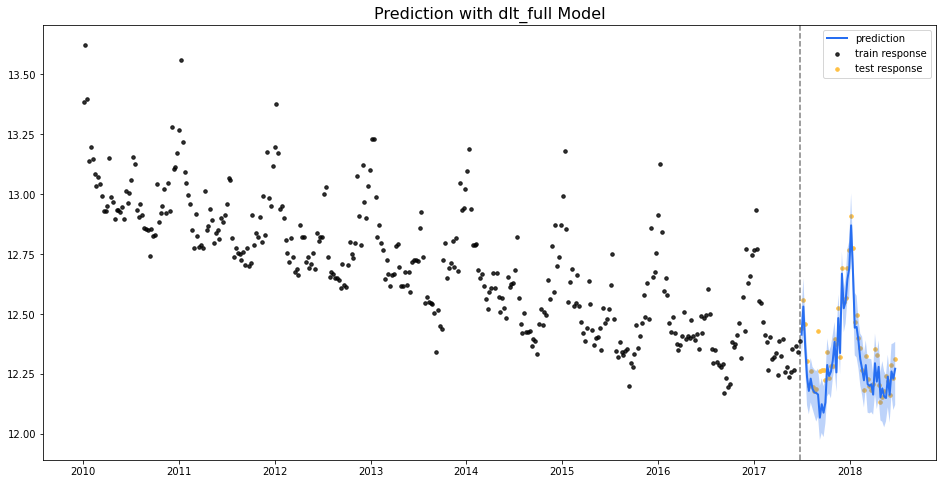

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,week,prediction,trend,seasonality,regression
0,2017-07-02,12.413688,12.357167,0.056521,0.0
1,2017-07-09,12.531109,12.355313,0.175796,0.0
2,2017-07-16,12.379667,12.353444,0.026223,0.0
3,2017-07-23,12.234367,12.351561,-0.117194,0.0
4,2017-07-30,12.185118,12.349669,-0.164551,0.0


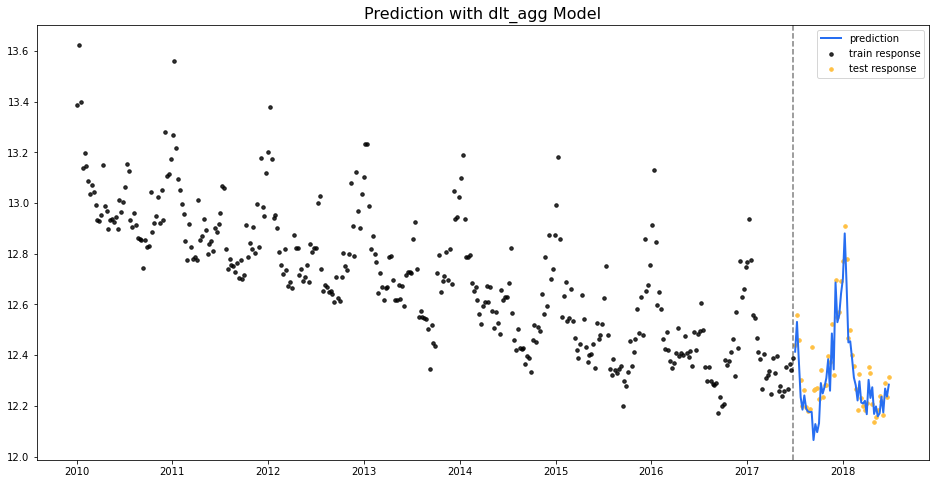

In [41]:
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
import matplotlib.pyplot as plt

model_key_list = [model_key for model_key in config['dlt_uber_provided_example'].keys() if 'dlt_' in model_key]
# print(model_key_list)
for k in model_key_list:
    dlt = DLT(
        response_col=RESPONSE_COL,
        date_col=TIME_COL,
        estimator=config['dlt_uber_provided_example'][k]['estimator'].get(),
        seasonality=config['dlt_uber_provided_example'][k]['seasonality'].get(),
        seed=config['dlt_uber_provided_example']['utils']['seed'].get()
    )
    if (config['dlt_uber_provided_example'][k]['estimator'].get()=="stan-mcmc"):
        dlt.fit(
            df=train_df,
            point_method=config['dlt_uber_provided_example'][k]['point_method'].get()
            )
    else:
        dlt.fit(
            df=train_df
            )
    pred_df = dlt.predict(df=test_df, decompose=True)
    display(pred_df.head())
    # plt.style.available
    ### open issue on orbit around the plt.style https://github.com/uber/orbit/issues/690
    plot_predicted_data(
        training_actual_df=train_df,
        predicted_df=pred_df,
        date_col=TIME_COL,
        actual_col=RESPONSE_COL,
        test_actual_df=test_df,
        title=f"Prediction with {k} Model",
        use_orbit_style=False);

### DLT Model - Global Trend Option

* ```DLT``` has 2 main differences to ```LGT```
    1. DLT introduces a damped factor on local Trend
    2. DLT models global trend as a deterministic projection with 4 options ```global_trend_option```
        1. ```linear```
        2. ```loglinear```
        3. ```logistic```
        4. ```flat```


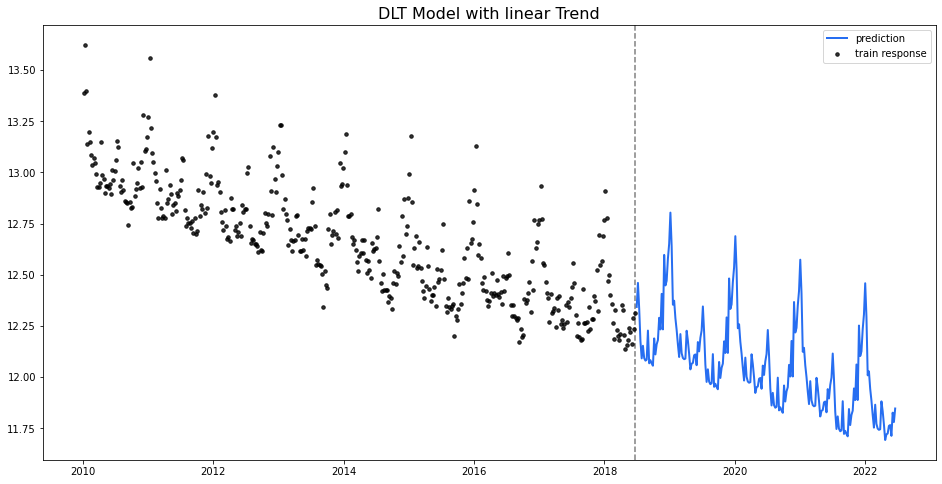

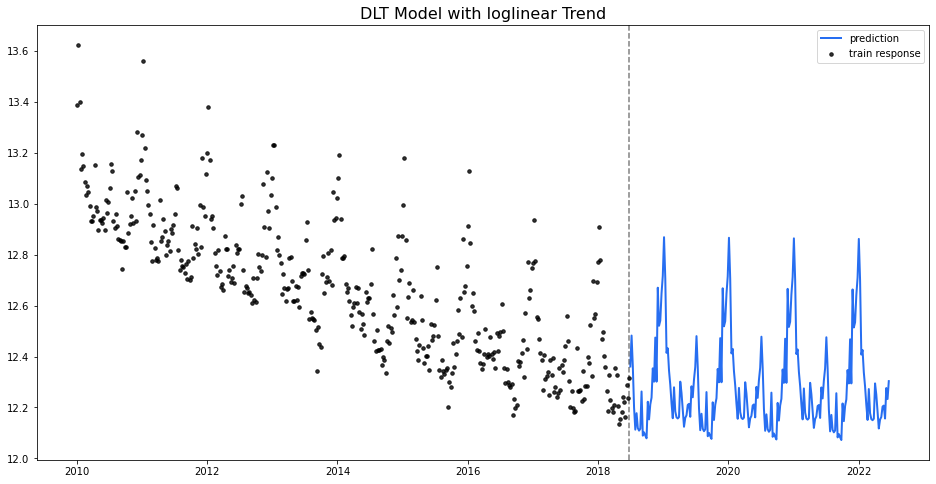

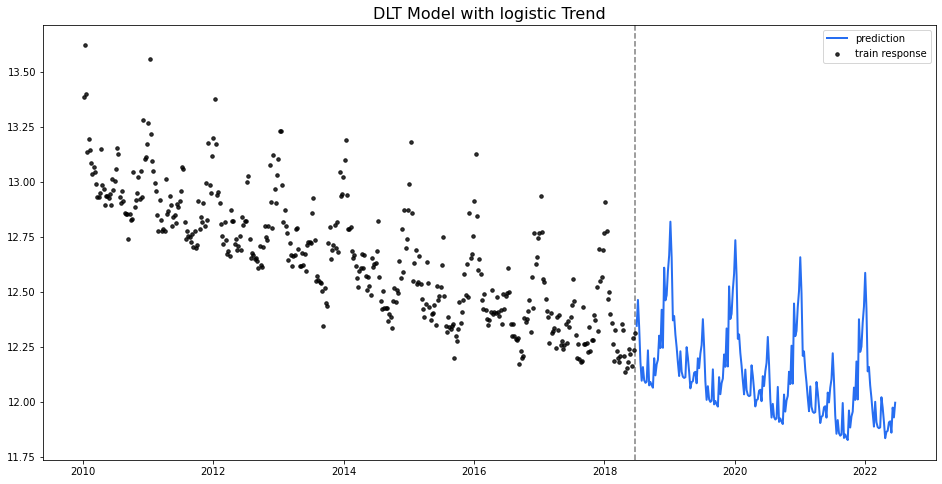

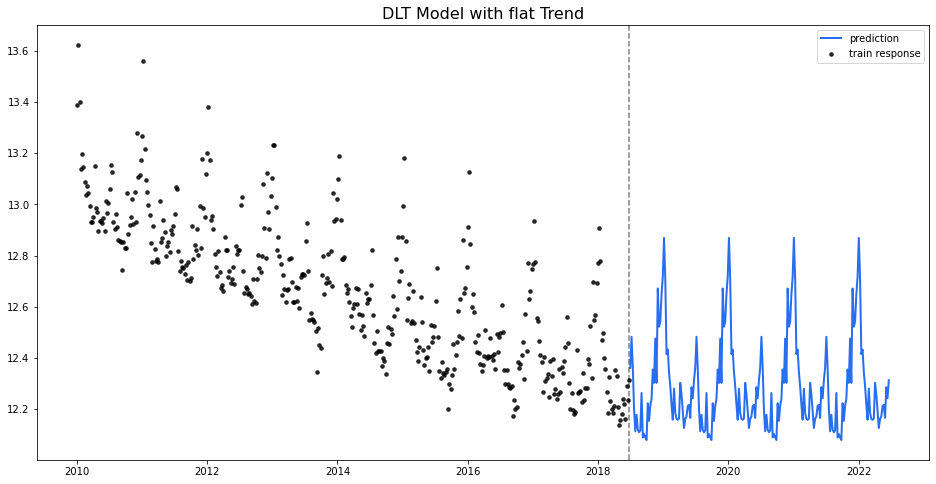

In [46]:
from datetime import timedelta

num_periods = 52 * 4
freq = 7
last_dt = (us_unemp_claims_df[TIME_COL].dt.to_pydatetime())[-1]
dts = [last_dt + timedelta(days=x*freq) for x in range(1, num_periods + 1)]
future_df = pd.DataFrame(dts, columns=[TIME_COL])
for selected_option in config['dlt_uber_provided_example']['utils']['global_trend_option_list'].get():
    dlt = DLT(response_col=RESPONSE_COL,
              date_col=TIME_COL,
              estimator=config['dlt_uber_provided_example']['dlt_map']['estimator'].get(),
              seasonality=config['dlt_uber_provided_example']['dlt_map']['seasonality'].get(),
              seed=config['dlt_uber_provided_example']['utils']['seed'].get(),
              global_trend_option=selected_option)
    dlt.fit(
        df=us_unemp_claims_df
        )
    pred_df = dlt.predict(df=future_df, decompose=True)
    plot_predicted_data(
        training_actual_df=us_unemp_claims_df,
        predicted_df=pred_df, 
        date_col=TIME_COL,
        actual_col=RESPONSE_COL,
        title=f'DLT Model with {selected_option} Trend',
        use_orbit_style=False);